In [1]:
%run 'utils/imports_3.ipynb'

## KNN - K-Nearest Neighbours - K-najbliższych sąsiadów

Algorytm K-najbliższych sąsiadów (ang. _k-nearest neighbours_, _k-nn_) to algorytm używany między innymi w statystyce w celu prognozy wartości zmiennych losowych [[1](https://pl.wikipedia.org/wiki/K_najbliższych_sąsiadów)], jak również do klasyfikacji. Niniejszy skrypt prezentuje zasadę działania algorytmu pod kątem klasyfikacji.

K-nn należy do algorytmów uczenia nadzorowanego. 

#### Zasada działania algorytmu

Zmienna `C` poddawana klasyfikacji umieszczana jest w n-wymiarowej przestrzeni zgodnie z jej atrybutami. Następnie wybieranych jest `k` obserwacji ze zbioru uczącego najbliższych do `C`. O klasyfikacji decyduje przynależność do klasy najbardziej licznej grupy z `k` najbliższych obserwacji.  

Odległość pomiędzy punktami może być obliczona używając metryki Euklidesowej [[2](https://pl.wikipedia.org/wiki/Odległość_euklidesowa)] lub metryki Mahalanobisa [[3](https://pl.wikipedia.org/wiki/Odległość_Mahalanobisa)]. Oprócz odległości można zastosować np. średnią arytmetyczną lub medianę.

#### Odległość Euklidesowa

W niniejszym skrypcie, podczas obliczania `k` najbliższych sąsiadów zmiennej, używana jest odległość Euklidesowa:

$$\sqrt{(q_{1} - p_{1})^2 + (q_{2} - p_{2})^2 + ... + (q_{i} - p_{i})^2}$$

-------

### Przykład 1 
Cena przesyłki pocztowej uzależniona jest od gabarytu paczki. Dostępne gabaryty to gabaryt A oraz gabaryt B. Celem jest stworzenie algorytmu przypisującego paczkę do algorytmu jedynie na podstawie znajomości tabeli z poprzednimi paczkami i ich gabarytami. Poniższa tabela prezentuje przykładowe dwie paczki i przynależność do gabarytu:

In [2]:
pd.DataFrame({'wysokość[cm]': [15, 20], 'szerokość[cm]': [30, 90], 'głębokość[cm]': [10, 20], "gabaryt": ["A", "B"]}, index=["Paczka 1", "Paczka 2"])

,gabaryt,głębokość[cm],szerokość[cm],wysokość[cm]
Paczka 1,A,10,30,15
Paczka 2,B,20,90,20


Nowa paczka, `Paczka 3`, która nie posiada wpisu w tabeli, ma następujące wymiary:
* Głębokość 15 cm,
* Szerokość 45 cm, 
* Wysokość 17 cm. 

Obliczając odległość euklidesową do obu paczek: 

_Paczka 3_ - _Paczka 1_ (Gabaryt A)

$$\sqrt{(15 - 10)^2 + (45 - 30)^2 + (15 - 17)^2} \approx 15.94 $$

_Paczka 3_ - _Paczka 2_ (Gabaryt B)

$$\sqrt{(15 - 20)^2 + (45 - 90)^2 + (15 - 20)^2} \approx 45.55 $$

Algorytm k-najbliższych sąsiadów, przy `k` = 1, sklasyfikowałby _Paczkę 3_ jako *Gabaryt A*, ponieważ odległość Euklidesowa jest najmniejsza dla sąsiada również sklasyfikowanego jako Gabaryt A.

---
### Przykład 2

Niech `X` oraz `Y` będą wygenerowanymi próbkami z losowymi atrybutami, podzielonymi na zbiór uczący i weryfikacyjny:

In [3]:
X, y = make_blobs(n_samples=400, centers=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)

Aby skorzystać z algorytmu k-nn, należy stworzyć i wytrenować odpowiedni klasyfikator. W tym przypadku wybieramy klasyfikator biorący pod uwagę liczbę sąsiadów zdefiniowaną w zmiennej `n_neighbors`:

In [4]:
n_neighbours = 4

knn = KNeighborsClassifier(n_neighbours, weights='distance')

Za pomocą funkcji `fit()` klasyfikator zostaje wytrenowany używając dostarczonych danych trenujących. Aby skorzystać z gotowego klasyfikatora, należy użyć funbkcji `predict()`. Oblicza ona odległości euklidesowe pomiędzy dostarczonymi danymi trenującymi, a dostarczonymi danymi weryfikacyjnymi:

In [5]:
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)

Aby zobaczyć skuteczność klasyfikacji, można skorzystać z funkcji `accuracy_score`:

In [6]:
accuracy_score(y_test, prediction)

0.9891304347826086

Poniższy wykres wizualizuje granice decyzyjne dla nowych punktów poddanych klasyfikacji:

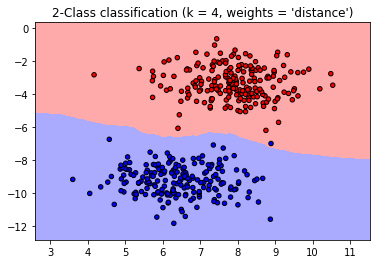

In [7]:
KNNPlotHelper().plot_decision_boundries(knn, X, y)

Wyraźny podział na klasy można również zauważyć na wykresie trójwymiarowym:

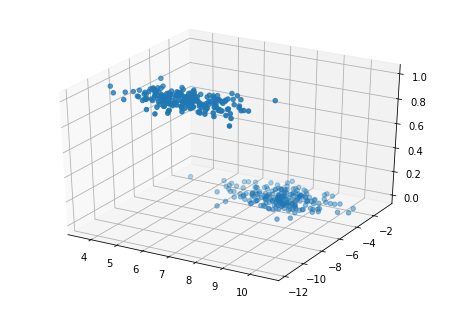

In [8]:
KNNPlotHelper().plot_3d(X, y)

---
## Optymalne `K `, walidacja krzyżowa - pliki ARFF

W kolejnej części skryptu zostanie przedstawiony proces wyznaczania optymalnego K, korzystając z k-krotnej walidacji krzyżowej.

Poniższa tablica zawiera wykorzystywane w [poprzednim skrypcie](2_SVM.ipynb) pliki ARFF:

In [9]:
arff_paths= ['data/car.arff',     #0
            'data/credit.arff',   #1
            'data/patient.arff',  #2
            'data/weather.arff']  #3

W celu wybrania konkretnej ścieżki pliku, należy odpowiednio zmodyfikować zmienną `arff_file_index`. 
Dane zostają załadowane do zmiennych `X` (atrybuty) oraz `y` (klasa).

In [10]:
arff_file_index = 0

data = load_arff(arff_paths[arff_file_index])
X = data.data
y = data.target

Optymalna wartość K poszukiwana jest spośród wartości w tablicy `k_list` - w tym przypadku są to wartości od 1 do 10 ze skokiem 2. Dla każdego z parametrów K zostaje wykonana 10-krotna walidacja krzyżowa. W ostatnim kroku wyniki zostają naniesione na wykres zależności błędu klasyfikacji od parametru K.

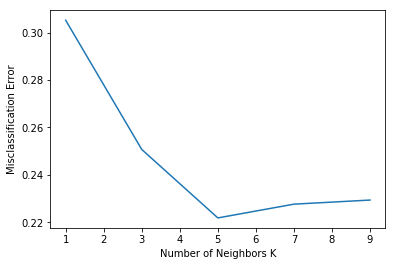

In [11]:
k_list = list(range(1, 10, 2))
results = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    results.append(scores.mean())
    
results = [1 - r for r in results]

plt.plot(k_list, results)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()